# Homework 7: Problems

### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018/blob/master/homework/HW7.ipynb

## Problem: use KDE to make Hess-like diagrams

Use Kernel Density Estimation (KDE) with a top-hat, Gaussian, and exponential 
kernel to analyze 4-D data for variable stars from the SDSS and LINEAR surveys:
-- SDSS u-g and g-i colors,
-- LINEAR variability period (logP) and variability amplitude (A), that
you already encountered in Homework 6. Please produce the g-i vs. u-g, and 
A vs. logP, diagrams for each of the three kernels above (that is, make the 
analogs of Figure 6.3 from the textbook). Experiment with different kernel 
bandwidths, plotting one that visually seems "best" (i.e., a good balance of 
bias vs. variance) for each kernel.

Please change the original figure size (i.e. the size of Figure 6.3) so that 
individual panels in your solution have aspect ratios closer to what is common 
for color-magnitude diagrams (i.e., x:y $\approx$ 4:6 or so).






<br>
# Homework 7: Solutions

### Some useful definitions and functions

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import norm
from scipy.spatial import cKDTree
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture as GMM
from sklearn.neighbors import KernelDensity
from astroML.datasets import fetch_LINEAR_geneva
from astroML.datasets import fetch_great_wall
from astroML.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
import matplotlib.cm as cm

/home/olena/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


## Problem 1
First obtain LINEAR data for 6,146 stars using astroML built-in function: 

In [2]:
data = fetch_LINEAR_geneva()
# N.B. this is a 7-dimensional dataset
ug = data['ug']
gi = data['gi']
logP = data['logP']
A = data['amp']
# will need for GMM clustering analysis
X = np.vstack([data['gi'], data['logP'], data['ug'],data['amp']]).T

and plot a few diagrams just to make sure that data are fine...

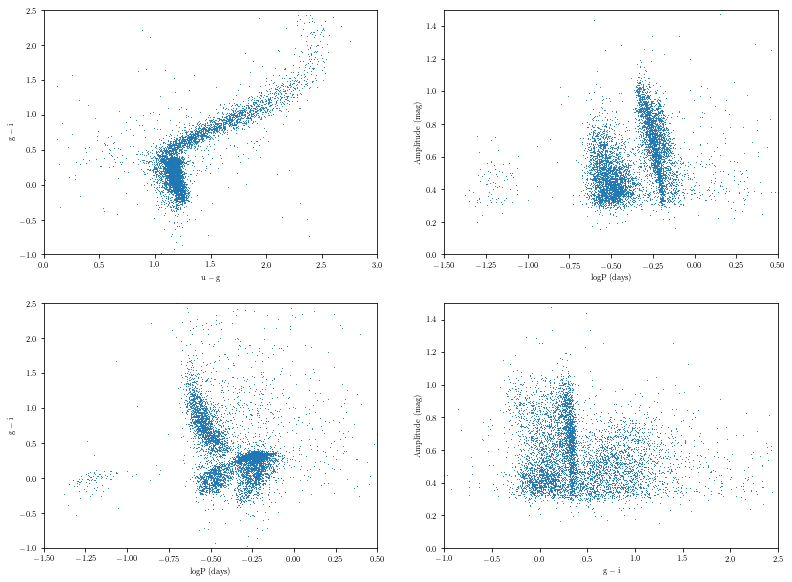

In [3]:
# set up the plot
fig = plt.figure(figsize=(12, 9), facecolor='w')
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.2, bottom=0.1, top=0.93)

# plot the color-color plot
ax1 = fig.add_subplot(221)
ax1.scatter(ug, gi, s=0.9, lw=0)
ax1.set_xlim(0.0, 3.0)
ax1.set_ylim(-1.0, 2.5)
ax1.set_xlabel(r'${\rm u-g}$', color='k')
ax1.set_ylabel(r'${\rm g-i}$', color='k')

# plot the A vs. logP plot
ax2 = fig.add_subplot(222)
ax2.scatter(logP, A, s=0.9, lw=0)
ax2.set_xlim(-1.5, 0.5)
ax2.set_ylim(0.0, 1.5)
ax2.set_xlabel(r'${\rm logP \, (days)}$', color='k')
ax2.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='k')

# g-i vs. logP
ax3 = fig.add_subplot(223)
ax3.scatter(logP, gi, s=0.9, lw=0)
ax3.set_xlim(-1.5, 0.5)
ax3.set_ylim(-1.0, 2.5)
ax3.set_xlabel(r'${\rm logP \, (days)}$', color='k')
ax3.set_ylabel(r'${\rm g-i}$', color='k')

# A vs. g-i 
ax4 = fig.add_subplot(224)
ax4.scatter(gi, A, s=0.9, lw=0)
ax4.set_xlim(-1.0, 2.5)
ax4.set_ylim(0.0, 1.5)
ax4.set_xlabel(r'${\rm g-i}$', color='k')
ax4.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='k')

plt.show()

And then do the required KDE analysis...

In [4]:
Nx = 300
Ny = 300
xmin, xmax = (-2, 3.5)
ymin, ymax = (-2, 3.0)

Nx1 = 300
Ny1 = 300
xmin1, xmax1 = (-1, 3)
ymin1, ymax1= (-1, 0.4)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

Xgrid1 = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin1, xmax1, Nx1),
                                            np.linspace(ymin1, ymax1, Ny1)))).T

X1 = np.vstack([data['gi'],data['ug']]).T
X2 = np.vstack([data['amp'],data['logP']]).T
kde1 = KernelDensity(0.001,kernel='gaussian') 
kde2 = KernelDensity(0.01,kernel='tophat')
kde3 = KernelDensity(0.00015,kernel='exponential')

kde11 = KernelDensity(0.00065,kernel='gaussian') 
kde21 = KernelDensity(0.0075,kernel='tophat')
kde31 = KernelDensity(0.00016,kernel='exponential')

log_dens1 = kde1.fit(X1).score_samples(Xgrid)
dens1 = X1.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))
log_dens2 = kde2.fit(X1).score_samples(Xgrid)
dens2 = X1.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))
log_dens3 = kde3.fit(X1).score_samples(Xgrid)
dens3 = X1.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))
log_dens11 = kde11.fit(X2).score_samples(Xgrid1)
dens11 = X2.shape[0] * np.exp(log_dens11).reshape((Ny1, Nx1))
log_dens21 = kde21.fit(X2).score_samples(Xgrid1)
dens21 = X2.shape[0] * np.exp(log_dens21).reshape((Ny1, Nx1))
log_dens31 = kde31.fit(X2).score_samples(Xgrid1)
dens31 = X2.shape[0] * np.exp(log_dens31).reshape((Ny1, Nx1))

### g-i vs u-gi

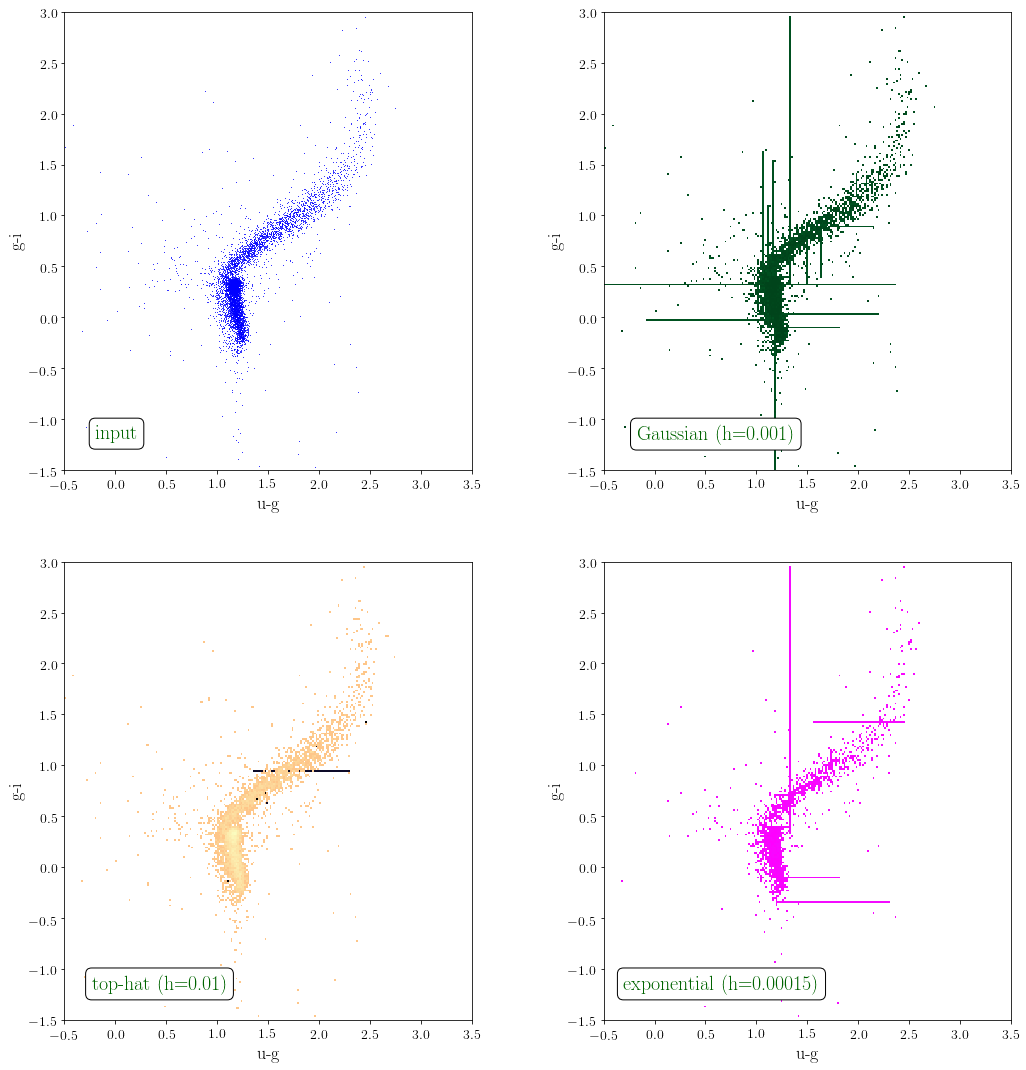

In [ ]:
fig = plt.figure(figsize=(18, 20))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.2, wspace=0.005)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X1[:, 1], X1[:, 0], s=1, lw=0, c='b')
ax1.text(0.18, 0.1, "input", ha='right', va='top',
         transform=ax1.transAxes,color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))
# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=cm.BuGn)
ax2.text(0.47, 0.1, "Gaussian (h=0.001)", ha='right', va='top',
         transform=ax2.transAxes, color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))
# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=cm.magma)
ax3.text(0.4, 0.1, "top-hat (h=0.01)", ha='right', va='top',
         transform=ax3.transAxes, color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))
# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=cm.cool)
ax4.text(0.53, 0.1, "exponential (h=0.00015)", ha='right', va='top',
         transform=ax4.transAxes, color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(-0.5, 3.5)
    ax.set_ylim(-1.5,3.0)

for ax in [ax1, ax2,ax3,ax4]:
    ax.set_xlabel(r'u-g',fontsize=18)

for ax in [ax1, ax2,ax3,ax4]:
    ax.set_ylabel(r'g-i',fontsize=18)
for ax in [ax1, ax2,ax3,ax4]:
    ax.tick_params(axis = 'both', which = 'major', labelsize = '14')


### A vs logP

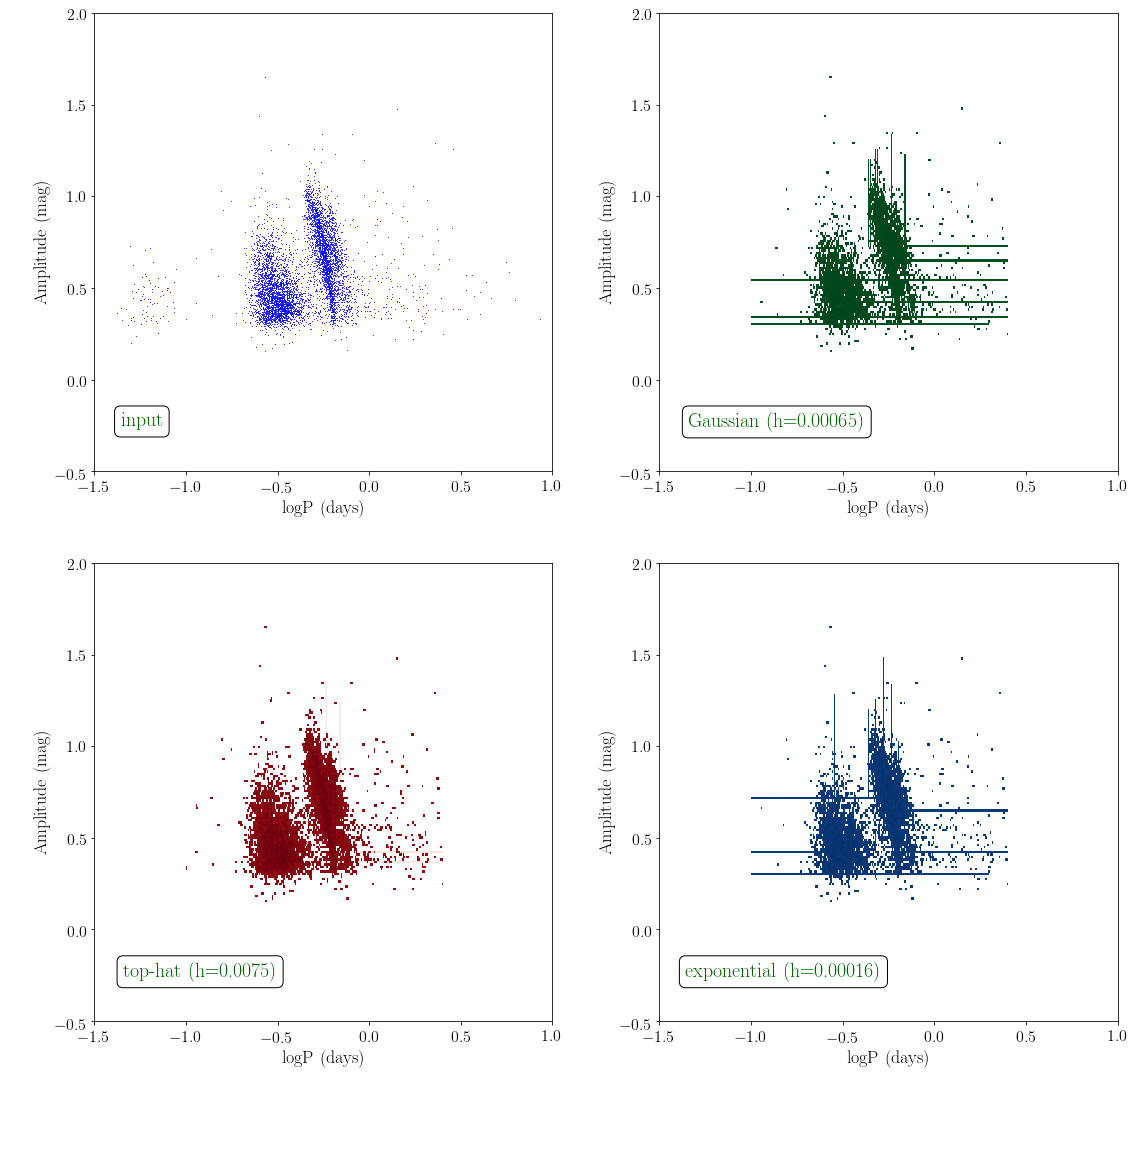

In [ ]:
fig1 = plt.figure(figsize=(18, 20))
fig1.subplots_adjust(left=0.12, right=0.99, bottom=0.2, top=0.9,
                    hspace=0.2, wspace=0.005)

# First plot: scatter the points
ax12 = plt.subplot(221, aspect='equal')
ax12.scatter(X2[:, 1], X2[:, 0], s=1, lw=0, c='blue')
ax12.text(-0.14, -0.22, "input", ha='right', va='top',
         transform=ax1.transAxes,color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))
# Second plot: gaussian kernel
ax22 = plt.subplot(222, aspect='equal')
ax22.imshow(dens11.T, origin='lower', norm=LogNorm(),
           extent=(ymin1, ymax1, xmin1, xmax1), cmap=cm.BuGn)
ax22.text(0.26, -0.22, "Gaussian (h=0.00065)", ha='right', va='top',
         transform=ax2.transAxes,color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))
# Third plot: top-hat kernel
ax32 = plt.subplot(223, aspect='equal')
ax32.imshow(dens21.T, origin='lower', norm=LogNorm(),
           extent=(ymin1, ymax1, xmin1, xmax1), cmap=cm.Reds)
ax32.text(0.14, -.22, "top-hat (h=0.0075)", ha='right', va='top',
         transform=ax3.transAxes,color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))
# Fourth plot: exponential kernel
ax42 = plt.subplot(224, aspect='equal')
ax42.imshow(dens31.T, origin='lower', norm=LogNorm(),
           extent=(ymin1, ymax1, xmin1, xmax1), cmap=cm.Blues)

ax42.text(0.3, -0.22, "exponential (h=0.00016)", ha='right', va='top',
         transform=ax4.transAxes, color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax12, ax22, ax32, ax42]:
    ax.set_xlim(-1.5, 1.0)
    ax.set_ylim(-0.5,2.0)

for ax in [ax12, ax22,ax32,ax42]:
    ax.set_xlabel(r'logP (days)',fontsize=18)

for ax in [ax12, ax22,ax32,ax42]:
    ax.set_ylabel(r'Amplitude (mag)',fontsize=18)
for ax in [ax12, ax22,ax32,ax42]:
    ax.tick_params(axis = 'both', which = 'major', labelsize = '16')


## Below everything done above is repeated, but with higher h values

In [ ]:
Nx = 100
Ny = 100
xmin, xmax = (-2, 3.5)
ymin, ymax = (-1, 4.0)

Nx1 = 100
Ny1 = 100
xmin1, xmax1 = (-1.5, 3.0)
ymin1, ymax1= (-2.5, 2)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

Xgrid1 = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin1, xmax1, Nx1),
                                            np.linspace(ymin1, ymax1, Ny1)))).T

X1 = np.vstack([data['gi'],data['ug']]).T
X2 = np.vstack([data['amp'],data['logP']]).T
kde1 = KernelDensity(0.3,kernel='gaussian') 
kde2 = KernelDensity(1.7,kernel='tophat')
kde3 = KernelDensity(0.07,kernel='exponential')

kde11 = KernelDensity(0.3,kernel='gaussian') 
kde21 = KernelDensity(2,kernel='tophat')
kde31 = KernelDensity(0.7,kernel='exponential')

log_dens1 = kde1.fit(X1).score_samples(Xgrid)
dens1 = X1.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))
log_dens2 = kde2.fit(X1).score_samples(Xgrid)
dens2 = X1.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))
log_dens3 = kde3.fit(X1).score_samples(Xgrid)
dens3 = X1.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))
log_dens11 = kde11.fit(X2).score_samples(Xgrid1)
dens11 = X2.shape[0] * np.exp(log_dens11).reshape((Ny1, Nx1))
log_dens21 = kde21.fit(X2).score_samples(Xgrid1)
dens21 = X2.shape[0] * np.exp(log_dens21).reshape((Ny1, Nx1))
log_dens31 = kde31.fit(X2).score_samples(Xgrid1)
dens31 = X2.shape[0] * np.exp(log_dens31).reshape((Ny1, Nx1))

fig = plt.figure(figsize=(18, 20))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.2, wspace=0.005)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X1[:, 1], X1[:, 0], s=1, lw=0, c='b')
ax1.text(0.18, 0.1, "input", ha='right', va='top',
         transform=ax1.transAxes,color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))
# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=cm.viridis)
ax2.text(0.47, 0.1, "Gaussian (h=0.3)", ha='right', va='top',
         transform=ax2.transAxes, color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))
# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=cm.magma)
ax3.text(0.4, 0.1, "top-hat (h=1.7)", ha='right', va='top',
         transform=ax3.transAxes, color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))
# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=cm.cool)
ax4.text(0.53, 0.1, "exponential (h=0.03)", ha='right', va='top',
         transform=ax4.transAxes, color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax)
    ax.set_ylim(xmin,xmax)

for ax in [ax1, ax2,ax3,ax4]:
    ax.set_xlabel(r'u-g',fontsize=18)

for ax in [ax1, ax2,ax3,ax4]:
    ax.set_ylabel(r'g-i',fontsize=18)
for ax in [ax1, ax2,ax3,ax4]:
    ax.tick_params(axis = 'both', which = 'major', labelsize = '14')

In [ ]:
fig1 = plt.figure(figsize=(18, 20))
fig1.subplots_adjust(left=0.12, right=0.99, bottom=0.2, top=0.9,
                    hspace=0.2, wspace=0.005)

# First plot: scatter the points
ax12 = plt.subplot(221, aspect='equal')
ax12.scatter(X2[:, 1], X2[:, 0], s=1, lw=0, c='blue')
ax12.text(-0.1, -0.22, "input", ha='right', va='top',
         transform=ax1.transAxes,color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))
# Second plot: gaussian kernel
ax22 = plt.subplot(222, aspect='equal')
ax22.imshow(dens11.T, origin='lower', norm=LogNorm(),
           extent=(ymin1, ymax1, xmin1, xmax1), cmap=cm.plasma)
ax22.text(0.18, -0.22, "Gaussian (h=0.3)", ha='right', va='top',
         transform=ax2.transAxes,color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))
# Third plot: top-hat kernel
ax32 = plt.subplot(223, aspect='equal')
ax32.imshow(dens21.T, origin='lower', norm=LogNorm(),
           extent=(ymin1, ymax1, xmin1, xmax1), cmap=cm.Reds)
ax32.text(0.14, -.22, "top-hat (h=2)", ha='right', va='top',
         transform=ax3.transAxes,color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))
# Fourth plot: exponential kernel
ax42 = plt.subplot(224, aspect='equal')
ax42.imshow(dens31.T, origin='lower', norm=LogNorm(),
           extent=(ymin1, ymax1, xmin1, xmax1), cmap=cm.Blues)

ax42.text(0.3, -0.22, "exponential (h=0.7)", ha='right', va='top',
         transform=ax4.transAxes, color='darkgreen',fontsize='20',
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax12, ax22, ax32, ax42]:
    ax.set_xlim(ymin1,ymax1)
    ax.set_ylim(xmin1,xmax1)

for ax in [ax12, ax22,ax32,ax42]:
    ax.set_xlabel(r'logP (days)',fontsize=18)

for ax in [ax12, ax22,ax32,ax42]:
    ax.set_ylabel(r'Amplitude (mag)',fontsize=18)
for ax in [ax12, ax22,ax32,ax42]:
    ax.tick_params(axis = 'both', which = 'major', labelsize = '16')
